Temporal Order Preservation
- Unlike traditional datasets, time series data must be split while preserving the chronological order of observations. This means you cannot randomly shuffle the data before splitting, as the temporal dependencies are crucial for accurate modeling and forecasting.

Forward-Looking Validation
- Your validation and test sets should always be forward in time relative to your training set.
- This mimics real-world scenarios where you use historical data to predict future outcomes.

Key Considerations

- Forward-Looking Validation: The validation and test sets come after the training set in time, mimicking real-world forecasting scenarios.
No Shuffling: Unlike in traditional machine learning, we don't shuffle the data to maintain the time-dependent structure.

- Sufficient History: The training set includes a substantial portion of the data to capture long-term patterns and seasonality.
Future Performance Estimation: The validation set allows for tuning hyperparameters, while the test set provides an unbiased estimate of the model's performance on future, unseen data.

In [4]:
import pandas as pd
#import data
shampoo_sales = pd.read_csv('shampoo_sales.csv', parse_dates=['Month'] ,index_col='Month')


C:\Users\Rober\AppData\Local\Temp\ipykernel_6072\1349088429.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  shampoo_sales = pd.read_csv('shampoo_sales.csv', parse_dates=['Month'] ,index_col='Month')


In [6]:
shampoo_sales

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3
1-06,168.5
1-07,231.8
1-08,224.5
1-09,192.8


In [7]:
train_size = int(len(shampoo_sales) * 0.7)
val_size = int(len(shampoo_sales) * 0.2)
test_size = len(shampoo_sales) - train_size - val_size

train_data = shampoo_sales[:train_size]
validation_data = shampoo_sales[train_size:train_size + val_size]
test_data = shampoo_sales[train_size + val_size:]



In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime

def parse(x):
    return datetime.strptime('190'+x, '%Y-%m')

# Load the data
df = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parse).squeeze()

# Convert Series to DataFrame
df = df.to_frame(name='Sales')

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


# Create sequences for time series prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Create input sequence (X) of 'seq_length' time steps
        X.append(data[i:(i + seq_length), 0])
        # Create target value (y) which is the next value after the sequence
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Set the sequence length (lookback period)
seq_length = 3  # Number of time steps to look back

# Generate input sequences and target values
X, y = create_sequences(scaled_data, seq_length)

# Split the data
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the RNN model
model = Sequential([
    # Default activation function is 'tanh'
    SimpleRNN(50, input_shape=(seq_length, 1)),
    Dense(1)
])


# Build the RNN with relu, relu may perform better than tanh on simpler problems
# model = Sequential([
#     SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)),
#     Dense(1)
# ])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Train Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))

print(f'Train RMSE: {train_rmse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')

Epoch 1/100


C:\Users\Rober\AppData\Local\Temp\ipykernel_16084\298457940.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parse).squeeze()
C:\Users\Rober\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0369 - val_loss: 0.0169
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0149 - val_loss: 0.0814
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0241 - val_loss: 0.0542
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0181 - val_loss: 0.0276
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0158 - val_loss: 0.0366
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0131 - val_loss: 0.0636
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0150 - val_loss: 0.0732
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0154 - val_loss: 0.0614
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0162 - val_loss: 0.0407
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0214 - val_loss: 0.0352
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0215 - val_loss: 0.0516
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0144 - val_loss: 0.0744


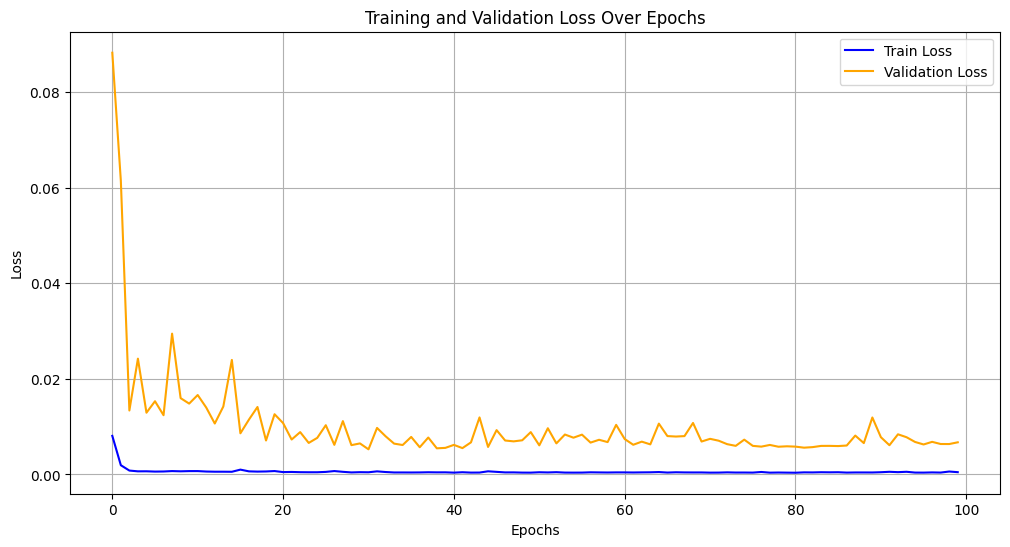

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load the data
df = pd.read_csv('crude-oil-price.csv', parse_dates=['date'], index_col='date')

# Use the 'price' column for modeling
df = df[['price']]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 3  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

# Split the data
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the RNN model
model = Sequential([
    LSTM(50, input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Train Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))

print(f'Train RMSE: {train_rmse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')

Epoch 1/100


C:\Users\Rober\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0130
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0095
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3618e-04 - val_loss: 0.0102
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2562e-04 - val_loss: 0.0091
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5760e-04 - val_loss: 0.0099
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2676e-04 - val_loss: 0.0126
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9443e-04 - val_loss: 0.0136
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0436e-04 - val_loss: 0.0098
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0336e-04 - val_loss: 0.0151
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8336e-04 - val_loss: 0.0073
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8860e-04 - val_loss: 0.0228
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━

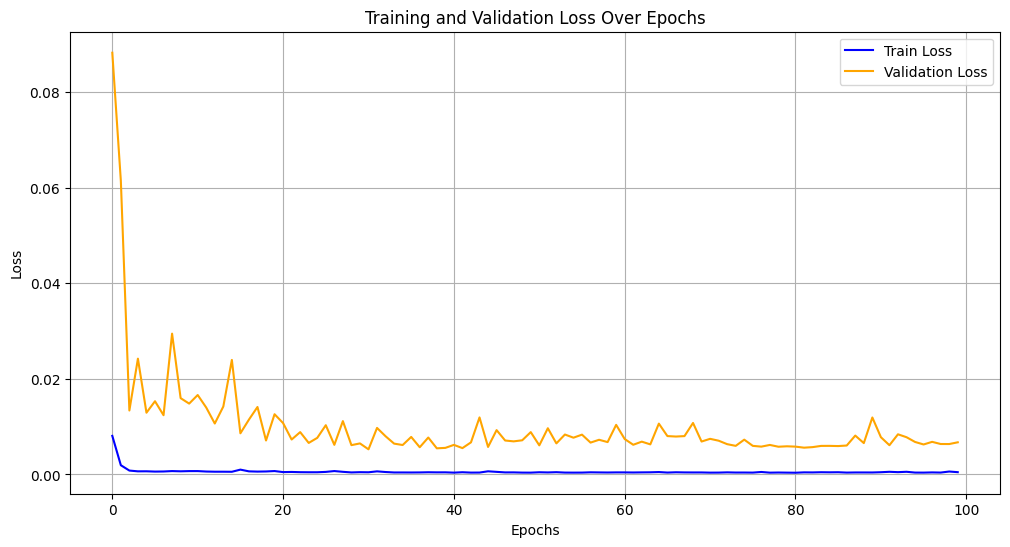

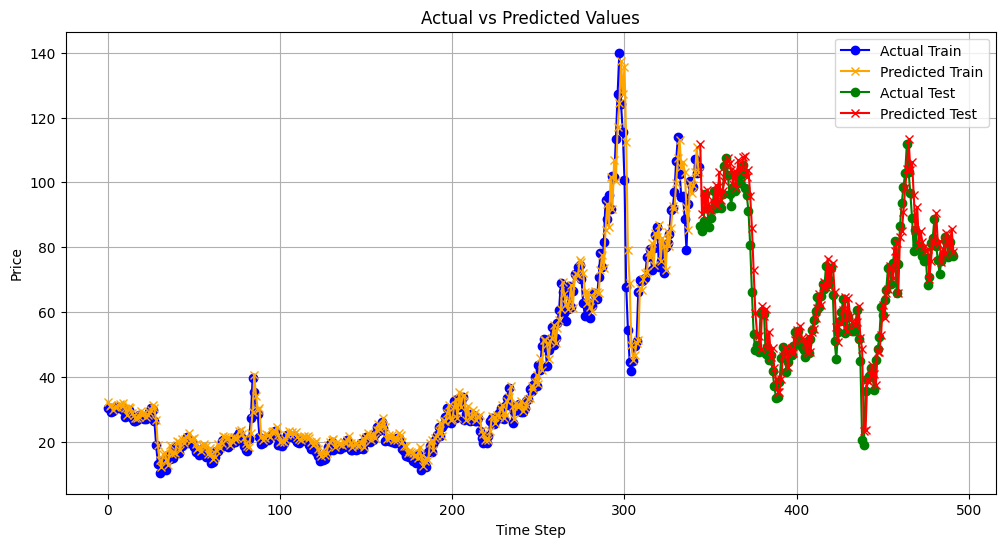

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_train_inv, label='Actual Train', marker='o', color='blue')
plt.plot(train_predict, label='Predicted Train', marker='x', color='orange')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, label='Actual Test', marker='o', color='green')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predict, label='Predicted Test', marker='x', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100


C:\Users\Rober\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0138 - val_loss: 0.0068
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0321
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0074
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0125
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 13/100

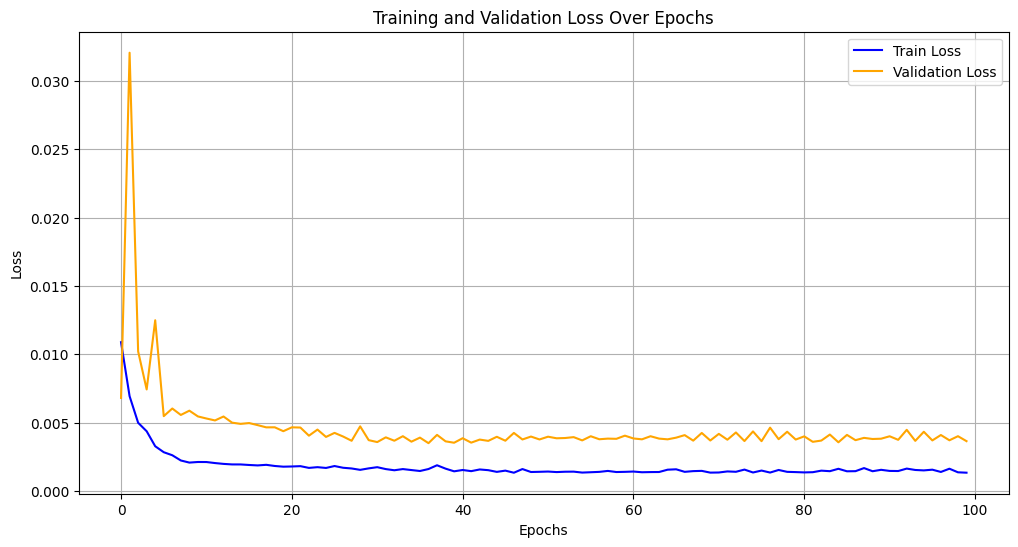

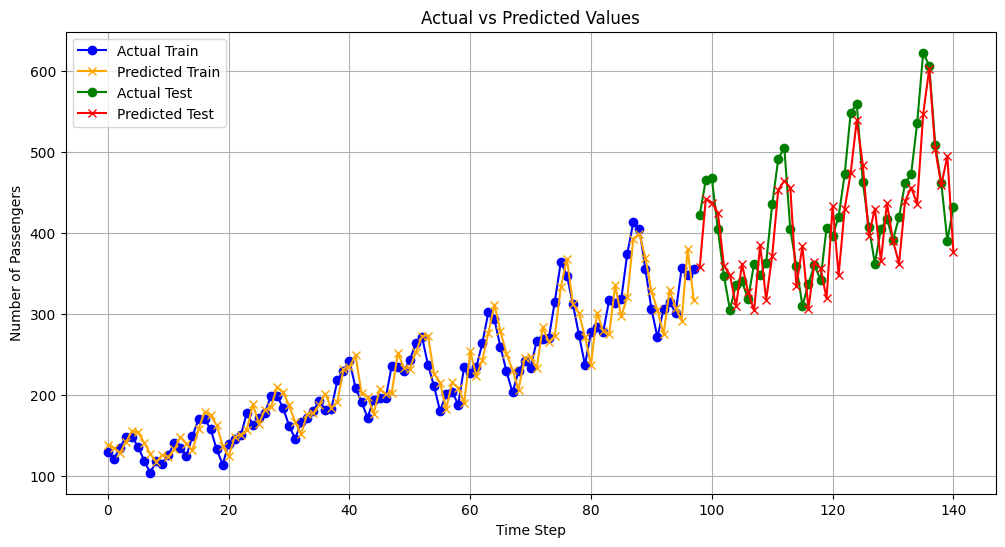

Train RMSE: 22.135
Test RMSE: 47.166


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('airpassengers.csv', parse_dates=['Month'], index_col='Month')

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 3  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

# Split the data
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the RNN model
model = Sequential([
    GRU(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_train_inv, label='Actual Train', marker='o', color='blue')
plt.plot(train_predict, label='Predicted Train', marker='x', color='orange')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, label='Actual Test', marker='o', color='green')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predict, label='Predicted Test', marker='x', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))

print(f'Train RMSE: {train_rmse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')

The RMSE (Root Mean Square Error) provides a measure of how far off the model's predictions are from the actual values in the same units as the data. Here's what the RMSE tells us for each dataset:

## Air Passengers Dataset
- Train RMSE: 22.581
- Test RMSE: 59.456

### Interpretation:
  The RMSE indicates that, on average, the model's predictions differ from the actual number of passengers by about 22.6 on the training set and 59.5 on the test set. This means the model is more accurate on the training data than on unseen data.


## Crude Oil Dataset
- Train RMSE: 5.300
- Test RMSE: 7.350
### Interpretation:
  The RMSE suggests that the model's predictions for oil prices are off by about $5.30 on the training set and $7.35 on the test set. This indicates a relatively good fit, with predictions being close to actual prices.


## Shampoo Sales Dataset
- Train RMSE: 79.627
- Test RMSE: 251.452
### Interpretation:
  The RMSE shows that the model's predictions for shampoo sales are off by about 79.6 units on the training set and 251.5 units on the test set. This large error suggests the model is struggling to accurately predict sales, especially on unseen data.

## General Insights
- Lower RMSE: Indicates more accurate predictions.
- Higher RMSE: Suggests larger prediction errors.
- Comparison: The difference between train and test RMSE can indicate overfitting (if the test RMSE is much higher than the train RMSE).
- In summary, RMSE provides a direct measure of prediction accuracy in the context of the specific units of each dataset (e.g., passengers, dollars, sales units).